In [1]:
import os 
import sys 

import os 
import sys 
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) 
if project_root not in sys.path: 
    sys.path.insert(0, project_root)

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import torch  
import minari 
import numpy as np
import faiss

from utils.sampling_states import sample_states
from models.cl_model import mlpCL
from data.TrajectorySet import TrajectorySet

from utils.remove_dupes import remove_dupes


In [2]:
# Resolving some weird faiss issues
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)
faiss.omp_set_num_threads(1)

# Solves a faiss issue with macbooks
sys.modules['faiss.swigfaiss_avx2'] = faiss

In [3]:
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
DEVICE = "cpu"
PROJECT_ROOT = project_root
TOTAL_STATES = 1_000_000

In [4]:
torch.cuda.is_available()

False

In [5]:
# Get all 4 models 

model_name_1 = "laplace.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_1) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    laplace_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


model_name_2 = "gaussian.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_2) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    gauss_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


model_name_3 = "exponential.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_3) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    expo_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


model_name_4 = "uniform.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name_4) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    uniform_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))


Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\laplace.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\gaussian.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\exponential.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\uniform.ckpt, loading...


In [6]:
# Get states from dataset
d = sample_states(MINARI_DATASET, TOTAL_STATES,)

# Preprocessor

In [7]:
def process_states(states) -> list: 
    """
    Takes in raw states and returns its corresponding 2D PCA embedding. 
    Args: 
        states: The raw states, of size [N, d]
    
    Returns: 
        A list of PCA embeddings from the 4 models in this order: 
        [pca_laplace, pca_gauss, pca_expo, pca_uniform]
    """
    # Convert subsampled states to latent represntation 
    new_states = torch.as_tensor(states, dtype=torch.float32)

    with torch.no_grad():
        laplace_z = laplace_model(new_states)
        gauss_z = gauss_model(new_states)
        expo_z = expo_model(new_states) 
        uniform_z = uniform_model(new_states)

    # Normalize representation embeddings 
    scaler_laplace = StandardScaler()
    scaler_gauss = StandardScaler()
    scaler_expo = StandardScaler()
    scaler_uniform = StandardScaler()

    norm_laplace_z = scaler_laplace.fit_transform(laplace_z)
    norm_gauss_z = scaler_gauss.fit_transform(gauss_z)
    norm_expo_z = scaler_expo.fit_transform(expo_z)
    norm_uniform_z = scaler_uniform.fit_transform(uniform_z)

    # PCA 
    pca_laplace_model = PCA(n_components=2)
    pca_gauss_model   = PCA(n_components=2)
    pca_expo_model    = PCA(n_components=2)
    pca_uniform_model = PCA(n_components=2)

    pca_laplace = pca_laplace_model.fit_transform(norm_laplace_z)
    pca_gauss = pca_gauss_model.fit_transform(norm_gauss_z)
    pca_expo = pca_expo_model.fit_transform(norm_expo_z)
    pca_uniform = pca_uniform_model.fit_transform(norm_uniform_z)

    return {"pca-reps": [pca_laplace, pca_gauss, pca_expo, pca_uniform], 
            "pca-models": [pca_laplace_model, pca_gauss_model, pca_expo_model, pca_uniform_model],
            "scalars": [scaler_laplace, scaler_gauss, scaler_expo, scaler_uniform]}


In [8]:
states = d["states"]

pca_dict = process_states(states)

pca_states = pca_dict["pca-reps"]

subsampled_pca_states = []
idx = np.random.choice(np.arange(TOTAL_STATES), size=10_000, replace=False)
for i in range(len(pca_states)): 
    subsampled_pca_states.append(pca_states[i][idx])

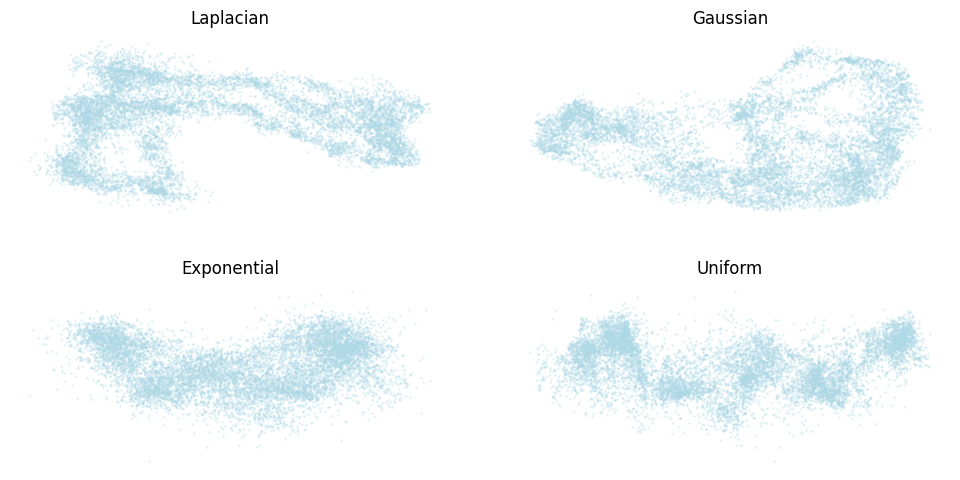

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10,5), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.3, h_pad=0.2)  # adjust padding

axs[0, 0].scatter(subsampled_pca_states[0][:, 0], subsampled_pca_states[0][:, 1], s=1, c="lightblue", alpha=0.25)
axs[0, 0].set_title("Laplacian")

axs[0, 1].scatter(subsampled_pca_states[1][:, 0], subsampled_pca_states[1][:, 1], s=1, c="lightblue", alpha=0.25)
axs[0, 1].set_title("Gaussian")

axs[1, 0].scatter(subsampled_pca_states[2][:, 0], subsampled_pca_states[2][:, 1], s=1, c="lightblue", alpha=0.25)
axs[1, 0].set_title("Exponential")

axs[1, 1].scatter(subsampled_pca_states[3][:, 0], subsampled_pca_states[2][:, 1], s=1, c="lightblue", alpha=0.25)
axs[1, 1].set_title("Uniform")

[ax.axis("off") for ax in axs.ravel()]

plt.show()

In [10]:
def pca_transform(states, pca_dict, dist_idx, model, has_representation = False) -> list[list]:
    """
    Transforms states into their pca transformation given an existing pca model to do so. 

    Args: 
        states: The input states to be PCA-ed
        pca_dict: The PCA information (models, scalars)
        dist_idx: The distribution to use: [laplace, gauss, expo, uniform]
        model: The model to use, which must correspond to the type of distribution.
        has_representation: A bool to decide if the input are raw states, or a representation.  
    
    Returns: 
        A [N, 2] list, which is the states being PCA-ed. 
    """

    pca_models = pca_dict["pca-models"]
    scalers = pca_dict["scalars"]

    pca_model = pca_models[dist_idx]
    scalar = scalers[dist_idx]

    if has_representation == False: 
        with torch.no_grad(): 
            z = model(torch.as_tensor(states, dtype=torch.float32))
    else: 
        z = states

    scaled_z = (z - torch.as_tensor(scalar.mean_, dtype=z.dtype)) / torch.as_tensor(scalar.scale_, dtype=z.dtype)

    mean = torch.as_tensor(pca_model.mean_, dtype=torch.float32)
    centered_z = scaled_z - mean

    W = torch.as_tensor(pca_model.components_, dtype=torch.float32)

    y = torch.matmul(centered_z, W.T)

    return y

In [11]:
# Sample two trajectories with less than ep_len in length

def sample_trajectories(n_episodes=2, ep_len=200):
    """
    Samples n trajectories that have less than a specified length.
    """
    trajs = []
    for i in range(n_episodes): 
        while True: 
            traj = MINARI_DATASET.sample_episodes(n_episodes=1)
            if len(traj[0].observations["observation"]) < ep_len: 
                trajs.append(traj)
                break
    return trajs


In [12]:
trajs = sample_trajectories(2, 200)
t1 = trajs[0][0].observations["observation"]
t2 = trajs[1][0].observations["observation"]


uniform_idx = 3
uni_t1 = pca_transform(t1, pca_dict, dist_idx=uniform_idx, model=uniform_model, has_representation=False)
uni_t2 = pca_transform(t2, pca_dict, dist_idx=uniform_idx, model=uniform_model, has_representation=False)

expo_idx = 2
expo_t1 = pca_transform(t1, pca_dict, dist_idx=expo_idx, model=expo_model, has_representation=False)
expo_t2 = pca_transform(t2, pca_dict, dist_idx=expo_idx, model=expo_model, has_representation=False)

gauss_idx = 1
gauss_t1 = pca_transform(t1, pca_dict, dist_idx=gauss_idx, model=gauss_model, has_representation=False)
gauss_t2 = pca_transform(t2, pca_dict, dist_idx=gauss_idx, model=gauss_model, has_representation=False)

laplace_idx = 0
laplace_t1 = pca_transform(t1, pca_dict, dist_idx=laplace_idx, model=laplace_model, has_representation=False)
laplace_t2 = pca_transform(t2, pca_dict, dist_idx=laplace_idx, model=laplace_model, has_representation=False)

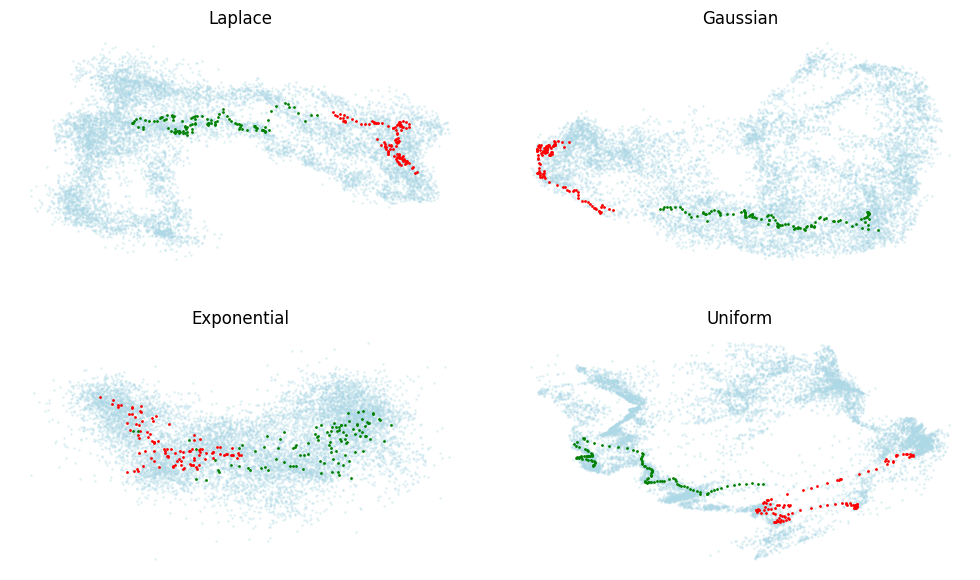

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10,6), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.2, h_pad=0.2)  # adjust padding

axs[0, 0].scatter(subsampled_pca_states[0][:, 0], subsampled_pca_states[0][:, 1], s=1, c="lightblue", alpha=0.25)
axs[0, 0].scatter(laplace_t1[:, 0], laplace_t1[:, 1], s=1, c= "red")
axs[0, 0].scatter(laplace_t2[:, 0], laplace_t2[:, 1], s=1, c= "green")
axs[0, 0].set_title("Laplace")
axs[0, 0].axis("off")

axs[0, 1].scatter(subsampled_pca_states[1][:, 0], subsampled_pca_states[1][:, 1], s=1, c="lightblue", alpha=0.25)
axs[0, 1].scatter(gauss_t1[:, 0], gauss_t1[:, 1],s=1, c= "red")
axs[0, 1].scatter(gauss_t2[:, 0], gauss_t2[:, 1], s=1,c= "green")
axs[0, 1].set_title("Gaussian")
axs[0, 1].axis("off")

axs[1, 0].scatter(subsampled_pca_states[2][:, 0], subsampled_pca_states[2][:, 1], s=1, c="lightblue", alpha=0.25)
axs[1, 0].scatter(expo_t1[:, 0], expo_t1[:, 1],s=1, c= "red")
axs[1, 0].scatter(expo_t2[:, 0], expo_t2[:, 1], s=1,c= "green")
axs[1, 0].set_title("Exponential")
axs[1, 0].axis("off")

axs[1, 1].scatter(subsampled_pca_states[3][:, 0], subsampled_pca_states[3][:, 1], s=1, c="lightblue", alpha=0.25)
axs[1, 1].scatter(uni_t1[:, 0], uni_t1[:, 1],s=1, c= "red")
axs[1, 1].scatter(uni_t2[:, 0], uni_t2[:, 1], s=1,c= "green")
axs[1, 1].set_title("Uniform")
axs[1, 1].axis("off")


plt.show()



# Clustering the State Space

Using the laplacian model

In [15]:
from models.cmhn import cmhn
from models.beta_model import LearnedBetaModel
from utils import visualizations

mhn = cmhn(update_steps=1, device=DEVICE, use_gpu=False)

# Get beta model
beta_model_name = "beta_model.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", beta_model_name) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    beta_model = LearnedBetaModel.load_from_checkpoint(
        pretrained_model_file, map_location=torch.device(DEVICE),
        cmhn = mhn, 
        device=DEVICE,
        )

Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\beta_model.ckpt, loading...


In [16]:
# Get z representations for all distributions
subsampled_states = states[idx]
models = [laplace_model, gauss_model, expo_model, uniform_model] # add expo model later 
z = []
for model in models: 
    with torch.no_grad(): 
        z.append(model(torch.as_tensor(subsampled_states, dtype=torch.float32)))
       

In [17]:
# Get beta
BETA = []
for reps in z:
    with torch.no_grad():
        BETA.append(beta_model.get_beta(reps))

# Put all z reps into cmhn to get U. 
U = [] 
U_norm = []
for i in range(len(z)): 
    u, u_norm = mhn.run(z[i], z[i], beta=BETA[i], run_as_batch=True)
    U.append(u)
    U_norm.append(u_norm)

In [19]:

# Remove duplicate / similar U values to get cluster points
unique_U = []
masks = []
for i in range(len(U)): 
    unique_mask = remove_dupes(U_norm[i], k=1000, threshold=0.5)
    unique_U.append(U[i][unique_mask])

    masks.append(unique_mask)


In [20]:
# Testing with laplace fixed points

print("U shape:" , U[0].shape)
fixed_pts = U[0][masks[0]]
print(fixed_pts.shape)
min_dist = float("inf")
mask = np.zeros(shape=(10_000), dtype=bool)

for i in range(fixed_pts.size(0)):
    saved_idx = 0
    min_dist = float('inf')
    for j in range(len(z[0])):
        euclidean_dist = np.linalg.norm(fixed_pts[i] - z[0][j])
        if euclidean_dist < min_dist: 
            min_dist = euclidean_dist
            saved_idx = j
    mask[saved_idx] = True

test = subsampled_states[mask]
test.shape

U shape: torch.Size([10000, 32])
torch.Size([16, 32])


(16, 4)

In [21]:
# Gets U values for specific distributions and PCA's them down to 2d to plot 

uniform_idx = 3
uni_U = pca_transform(unique_U[uniform_idx], pca_dict, dist_idx=uniform_idx, model=uniform_model, has_representation=True)

expo_idx = 2
expo_U = pca_transform(unique_U[expo_idx], pca_dict, dist_idx=expo_idx, model=expo_model, has_representation=True)

gauss_idx = 1
gauss_U = pca_transform(unique_U[gauss_idx], pca_dict, dist_idx=gauss_idx, model=gauss_model, has_representation=True)

laplace_idx = 0
laplace_U = pca_transform(unique_U[laplace_idx], pca_dict, dist_idx=laplace_idx, model=laplace_model, has_representation=True)


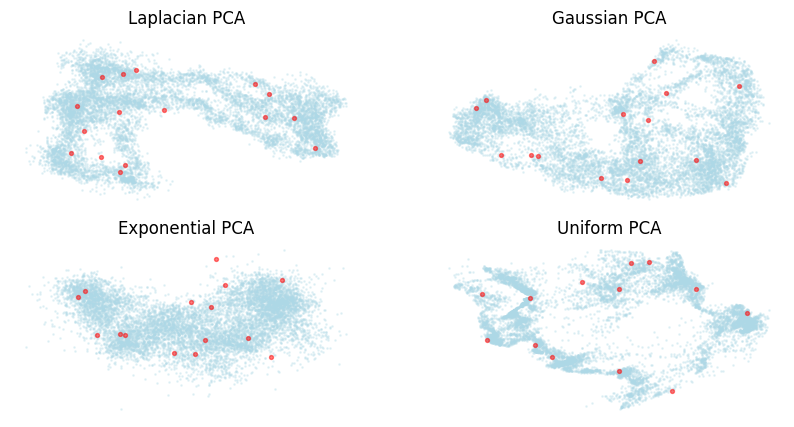

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs[0, 0].scatter(subsampled_pca_states[0][:, 0], subsampled_pca_states[0][:, 1], s=1, c="lightblue", alpha=0.25)
axs[0, 0].scatter(laplace_U[:, 0], laplace_U[:, 1], s=8, c= "red", alpha=0.5)
axs[0, 0].set_title("Laplacian PCA")
axs[0, 0].axis("off")

axs[0, 1].scatter(subsampled_pca_states[1][:, 0], subsampled_pca_states[1][:, 1], s=1, c="lightblue", alpha=0.25)
axs[0, 1].scatter(gauss_U[:, 0], gauss_U[:, 1],s=8, c= "red", alpha=0.5)
axs[0, 1].set_title("Gaussian PCA")
axs[0, 1].axis("off")

axs[1, 0].scatter(subsampled_pca_states[2][:, 0], subsampled_pca_states[2][:, 1], s=1, c="lightblue", alpha=0.25)
axs[1, 0].scatter(gauss_U[:, 0], gauss_U[:, 1],s=8, c= "red", alpha=0.5)
axs[1, 0].set_title("Exponential PCA")
axs[1, 0].axis("off")

axs[1, 1].scatter(subsampled_pca_states[3][:, 0], subsampled_pca_states[3][:, 1], s=1, c="lightblue", alpha=0.25)
axs[1, 1].scatter(uni_U[:, 0], uni_U[:, 1],s=8, c= "red", alpha=0.5)
axs[1, 1].set_title("Uniform PCA")
axs[1, 1].axis("off")

axs[1, 1].axis("off")

plt.show()

In [23]:
# Showing cluster points from Laplace distribution

dist_idx = laplace_idx
print(subsampled_states.shape)
print(z[dist_idx].shape)
print(U[dist_idx].shape)
print(unique_U[dist_idx].shape)

clustered_states = subsampled_states[masks[dist_idx]]
cluster_pts = clustered_states[:, :2]
cluster_test = test[:, :2]

(10000, 4)
torch.Size([10000, 32])
torch.Size([10000, 32])
torch.Size([16, 32])


# Visualize Cluster Points on the Real Maze 

Create a top-down visual of the Minari Large PointMaze environment to visualize where the cluster points are.

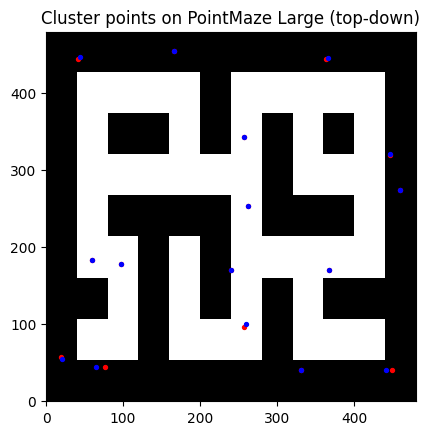

In [63]:

maze_map = np.array(
    [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
     [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], 
     [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1], 
     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], 
     [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1], 
     [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], 
     [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1], 
     [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1], 
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
)

env_height, env_width = 480, 480
x_params = (-5,5)
y_params = (-3.5, 3.5)

grid_points = visualizations.xy_to_grid(cluster_pts, x_params, y_params, env_height, env_width)
grid_points_2 = visualizations.xy_to_grid(cluster_test, x_params, y_params, env_height, env_width)

rows = [x[0] for x in grid_points]
cols = [x[1] for x in grid_points]

rows2 = [x[0] for x in grid_points_2]
cols2 = [x[1] for x in grid_points_2]
# === Plot ===
plt.imshow(maze_map, cmap="gray_r",
           extent=[0, env_width, 0, env_height], origin='upper')
plt.scatter(x = cols, y = rows, s=8, c="r")
plt.scatter(x = cols2, y = rows2, s=8, c="b")
plt.title("Cluster points on PointMaze Large (top-down)")

plt.show()

C:\Users\ray\AppData\Local\Temp\ipykernel_9228\4254910323.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


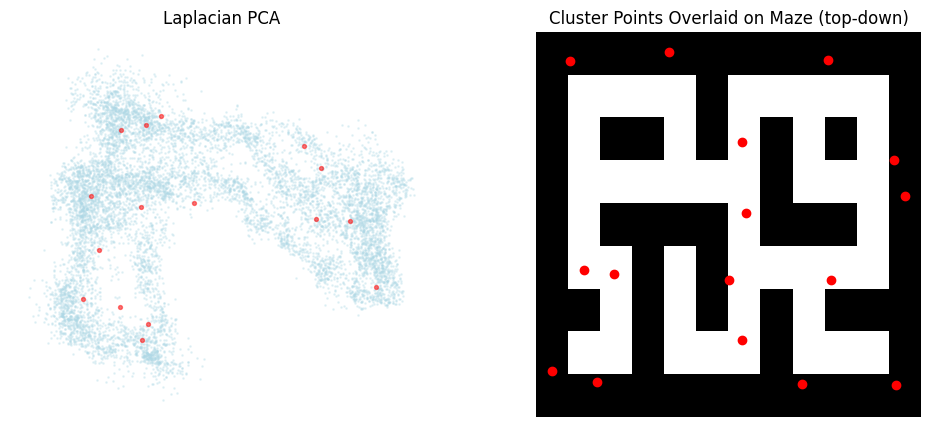

In [25]:
# Side by side comparison of the representation space PCA-ed down, and the actual maze environment.

fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].scatter(subsampled_pca_states[0][:, 0], subsampled_pca_states[0][:, 1], s=1, c="lightblue", alpha=0.25)
axs[0].scatter(laplace_U[:, 0], laplace_U[:, 1], s=8, c= "red", alpha=0.5)
axs[0].set_title("Laplacian PCA")
axs[0].axis("off")

axs[1].imshow(maze_map, cmap="gray_r", origin="upper",
           extent=[0, env_width, 0, env_height])
axs[1].plot(cols, rows, "ro")  # note cols = x-axis, rows = y-axis
axs[1].set_title("Cluster Points Overlaid on Maze (top-down)")
axs[1].axis("off")

fig.show()